In [16]:
import re
import math
import queue
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from scipy import stats
from pprint import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
data_folder = '../data/%s'

In [17]:
df_train = pd.read_csv(data_folder % 'train_final.csv')
df_train['date'] = pd.to_datetime(df_train['transcationDate'])
df_train = df_train.set_index('transcationDate').sort_index()
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train = df_train.reset_index()
df_train.columns

Index(['transcationDate', 'lat/lng', 'districtL', 'districtS', 'princeInHKD',
       'SFA', 'GFA', 'unitPriceSFA', 'unitPriceGFA', 'estateName', 'floor',
       'dis_mtr', 'dis_school', 'dis_market', 'areaSize', 'date', 'year',
       'month', 'day'],
      dtype='object')

In [18]:
LABEL = 'princeInHKD'
need_features_with_label = ['floor', 'dis_mtr',
       'dis_school', 'dis_market', 'areaSize', 'year', 'month', 'day','princeInHKD']

cate_features = ['districtL', 'districtS']
num_features = ['floor', 'dis_mtr','dis_school', 'dis_market', 'areaSize']
date_features = ['year', 'month', 'day']
df_train = df_train[need_features_with_label]
df_train.head()

,floor,dis_mtr,dis_school,dis_market,areaSize,year,month,day,princeInHKD
0,15,5.9657,0.0374,0.1482,882.0,2003,11,18,2200000.0
1,1,13284.9770,0.8929,1.4221,545.0,2004,6,1,1790000.0
2,7,3.7299,0.1577,0.0238,520.0,2004,6,1,945000.0
3,4,8.3495,0.1246,0.0263,585.0,2004,6,1,1950000.0
4,2,8.3495,0.1246,0.0263,983.0,2004,6,1,4950000.0


In [19]:
df_train['floor'] = df_train['floor'].replace('G','0').astype('int64')

In [20]:
mean = df_train[num_features].mean()
std = df_train[num_features].std()
label_nor = 20
print(mean)
print(std)

floor           7.580124
dis_mtr        39.725909
dis_school      0.163729
dis_market      0.225913
areaSize      594.412054
dtype: float64
floor           9.725491
dis_mtr       616.339621
dis_school      0.176334
dis_market      0.290479
areaSize      299.757712
dtype: float64


In [28]:
std.values

array([9.72549053e+00, 6.16339621e+02, 1.76333788e-01, 2.90479185e-01,
       2.99757712e+02])

In [21]:
df_train[num_features] = (df_train[num_features] - mean) / std
df_train[LABEL] = np.log(df_train[LABEL]) / label_nor

In [22]:
split_num = -1000
df_train_copy = pd.get_dummies(df_train)
train_data = df_train_copy[:split_num]
test_data = df_train_copy[split_num:]
test_data.head()

,floor,dis_mtr,dis_school,dis_market,areaSize,year,month,day,princeInHKD
515229,0.762931,-0.053815,-0.253663,-0.154616,3.221228,2018,8,2,0.879757
515230,1.482689,-0.038509,1.046712,0.175184,-0.134816,2018,8,2,0.780364
515231,-0.470940,-0.051358,-0.057444,1.766348,1.506510,2018,8,2,0.868285
515232,0.762931,-0.050866,-0.225875,0.553869,1.820096,2018,8,2,0.840562
515233,0.762931,-0.042505,0.140476,-0.349810,-0.014719,2018,8,2,0.784596


In [23]:
train_X = train_data.drop(LABEL,axis = 1)
train_y = train_data[LABEL]
val_X = test_data.drop(LABEL,axis = 1)
val_y = test_data[LABEL]

In [24]:
model_param = {'lr': 0.01, 'depth': 10, 'tree': 5000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'max_depth': model_param['depth'],
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'feature_fraction': 1,
    'bagging_fraction': model_param['sample'],
    'bagging_freq': 1,
    'bagging_seed': model_param['seed'],
    'verbose': 0
}

In [25]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(val_X, val_y)
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=5000,
    valid_sets=lgb_eval,
    verbose_eval = 100,
    early_stopping_rounds = 100
)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.0182746	valid_0's l2: 0.000625708
[200]	valid_0's l1: 0.0138276	valid_0's l2: 0.000424091
[300]	valid_0's l1: 0.011842	valid_0's l2: 0.000359458
[400]	valid_0's l1: 0.0107918	valid_0's l2: 0.000331537
[500]	valid_0's l1: 0.0100603	valid_0's l2: 0.000313748
[600]	valid_0's l1: 0.00958724	valid_0's l2: 0.00030325
[700]	valid_0's l1: 0.00928007	valid_0's l2: 0.000295996
[800]	valid_0's l1: 0.00902098	valid_0's l2: 0.000290335
[900]	valid_0's l1: 0.00882168	valid_0's l2: 0.000286171
[1000]	valid_0's l1: 0.00868244	valid_0's l2: 0.000283063
[1100]	valid_0's l1: 0.00855751	valid_0's l2: 0.000280136
[1200]	valid_0's l1: 0.00845096	valid_0's l2: 0.000278095
[1300]	valid_0's l1: 0.00835908	valid_0's l2: 0.000276035
[1400]	valid_0's l1: 0.00827731	valid_0's l2: 0.000274312
[1500]	valid_0's l1: 0.00822122	valid_0's l2: 0.000272949
[1600]	valid_0's l1: 0.00816547	valid_0's l2: 0.000272037
[1700]	valid_0's l1: 0.00

In [30]:
gbm.save_model('gbm_for_web.txt',num_iteration=gbm.best_iteration)

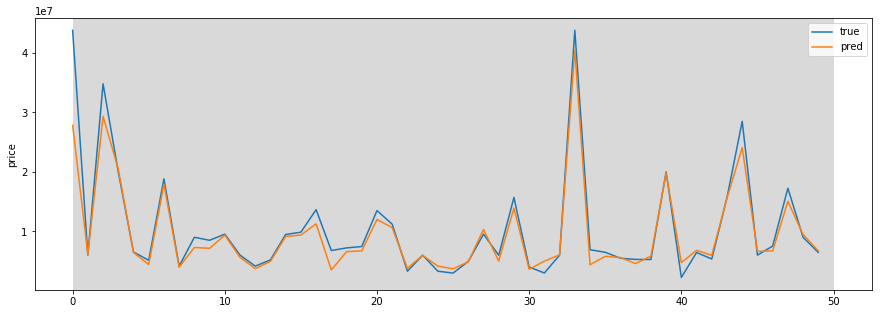

In [13]:
ypred = gbm.predict(val_X) * 20.0
ypred = np.power(np.e,ypred)
val_y = np.power(np.e,val_y * 20.0)
myplot(val_y,ypred,50)

In [12]:
def myplot(val_y,ypred,warmup_steps):
    df_plot = pd.DataFrame()
    df_plot['true'] = pd.Series(val_y.values)
    df_plot['pred'] = pd.Series(ypred)
#     warmup_steps = 50
    signal_pred = df_plot[['pred']][:warmup_steps]

    # Get the true output-signal from the data-set.
    signal_true = df_plot[['true']][:warmup_steps]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')

    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

    # Plot labels etc.
    plt.ylabel('price')
    plt.legend()
    plt.show()

In [15]:
val_X.columns

Index(['floor', 'dis_mtr', 'dis_school', 'dis_market', 'areaSize', 'year',
       'month', 'day'],
      dtype='object')